# Imports & Model Setup

In [1]:
import sys, os

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

import seaborn as sns
import pandas as pd
import numpy as np
from note_seq import midi_to_note_sequence, note_sequence_to_midi_file, note_sequence_to_pretty_midi
from heatmap import heatmap, corrplot
from src.evaluation import mgeval
from src.io import output, input, conversion
from src.generation import MusicVAEGenerator
from src.db import connection as db

In [2]:
import music21
#music21.configure.run()
#music21.environment.set('musescoreDirectPNGPath', 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe')
#music21.environment.set('musicxmlPath', 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe')

In [3]:
vae = MusicVAEGenerator()

[GEN] Initializing Music VAE with checkpoint 'cat-mel_2bar_big'...
INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, CategoricalLstmDecoder, and hparams:
{'max_seq_len': 32, 'z_size': 512, 'free_bits': 0, 'max_beta': 0.5, 'beta_rate': 0.99999, 'batch_size': 4, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [2048, 2048, 2048], 'enc_rnn_size': [2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'inverse_sigmoid', 'sampling_rate': 1000, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}
INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [2048]

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
INFO:tensorflow:
Decoder Cells:
  units: [2048, 2048, 2048]

Instructions for u

KeyboardInterrupt: 

# Input Analysis

In [32]:
midi = input.loadMidiFile('../midi/examples/monophonic/bohemian_mama_4b.mid')
seq_input = midi_to_note_sequence(midi)

metrics1 = mgeval.analyze_sequence(seq_input)
metrics1

{'pitch_count': 5,
 'pitch_count_per_bar': array([[1.],
        [3.],
        [4.],
        [4.]]),
 'pitch_class_histogram': array([0.16262471, 0.        , 0.59121931, 0.14599724, 0.        ,
        0.06419244, 0.        , 0.        , 0.        , 0.        ,
        0.0359663 , 0.        ]),
 'pitch_class_histogram_per_bar': array([[0.        , 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.15964004, 0.        , 0.71281229, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.12754767, 0.        ],
        [0.31055901, 0.        , 0.2715173 , 0.32120674, 0.        ,
         0.09671695, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.16898235, 0.        , 0.36323159, 0.28753822, 0.        ,
         0.18024784, 0.        , 0.        , 0.        , 0.        ,
         0.       

# Generate New Sequence

In [60]:
seq_gen_base = vae.generate(16, 0.6)
print(seq_gen_base['meta'])

{'gen_dur': 4.877166271209717, 'model': 'MusicVAE', 'checkpoint': 'cat-mel_2bar_big', 'temperature': 0.6}


# Gen_base Analysis

In [61]:
metrics2 = mgeval.analyze_sequence(seq_gen_base['sequence'])
distances = mgeval.calc_distances(metrics1, metrics2)

seq_gen_base['evaluation'] = {
    'metrics': metrics2,
    'distances_to_input': distances
}

metrics2

{'pitch_count': 6,
 'pitch_count_per_bar': array([[3.],
        [4.],
        [4.],
        [4.]]),
 'pitch_class_histogram': array([0.19029126, 0.        , 0.        , 0.04660194, 0.18834951,
        0.43300971, 0.        , 0.14174757, 0.        , 0.        ,
        0.        , 0.        ]),
 'pitch_class_histogram_per_bar': array([[0.        , 0.        , 0.        , 0.17777778, 0.        ,
         0.82222222, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.38509317, 0.        , 0.        , 0.        , 0.30434783,
         0.08074534, 0.        , 0.22981366, 0.        , 0.        ,
         0.        , 0.        ],
        [0.09836066, 0.        , 0.        , 0.        , 0.19672131,
         0.60655738, 0.        , 0.09836066, 0.        , 0.        ,
         0.        , 0.        ],
        [0.24742268, 0.        , 0.        , 0.        , 0.24742268,
         0.25773196, 0.        , 0.24742268, 0.        , 0.        ,
         0.       

## Example Plot: Note Length Transition Matrix

Note Length Transitions - Input


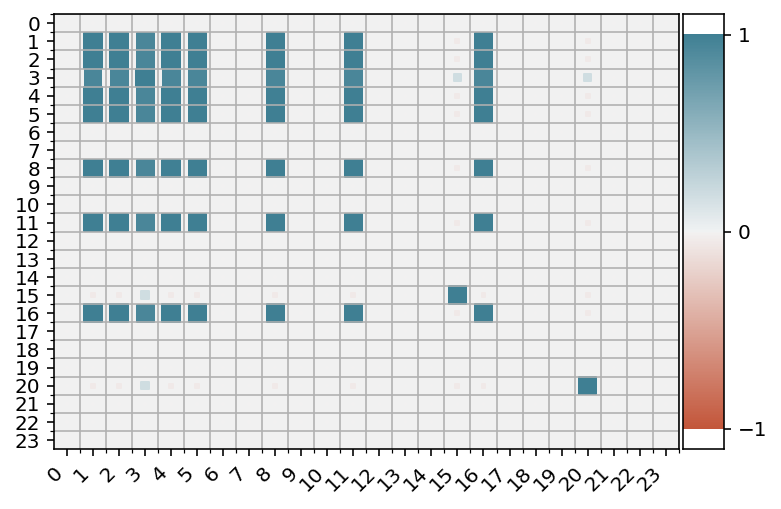

In [41]:
df1 = pd.DataFrame(metrics1['note_length_transition_matrix'])
corrplot(df1.corr(), size_scale=75)
print("Note Length Transitions - Input")

Note Length Transitions - Generation


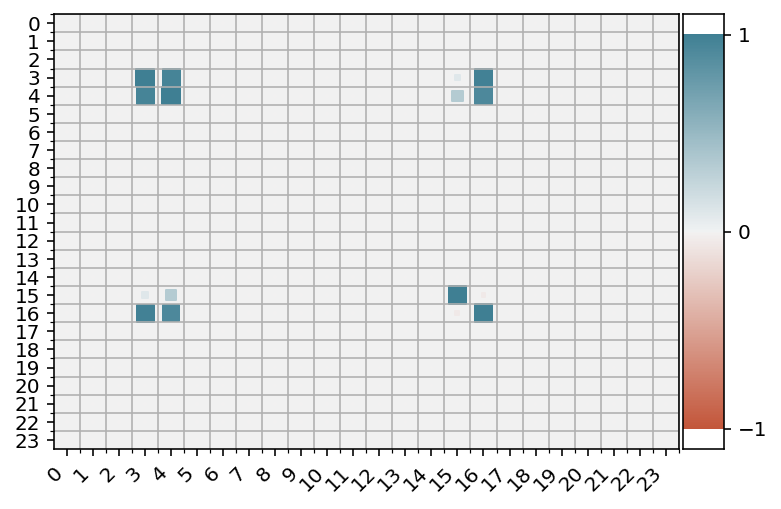

In [62]:
df2 = pd.DataFrame(metrics2['note_length_transition_matrix'])
corrplot(df2.corr(), size_scale=75)
print("Note Length Transitions - Generation")

## Piano Roll

In [63]:
output.pianoRollFromNoteSeq(seq_input)
output.pianoRollFromNoteSeq(seq_gen_base['sequence'])

Loading BokehJS ...

Loading BokehJS ...

## Similarity between input and gen_base

In [64]:
distances

{'pitch_count': 1.0,
 'pitch_count_per_bar': 2.23606797749979,
 'pitch_class_histogram': 0.7436886466812348,
 'pitch_class_histogram_per_bar': 1.8205103422591007,
 'pitch_class_transition_matrix': 6.855654600401044,
 'avg_pitch_interval': 1.7604166666666667,
 'pitch_range': 7.0,
 'note_count': 14.0,
 'note_count_per_bar': 8.602325267042627,
 'note_length_histogram': 0.4459035951163754,
 'note_length_transition_matrix': 19.6468827043885,
 'avg_ioi': 0.3111971788194444}

# Conversion to music21 stream

In [55]:
input_stream = conversion.note_seq_to_music21(seq_input)
input_stream.show('midi')

In [77]:
output_stream = conversion.note_seq_to_music21(seq_gen_base['sequence'])
output_stream.show('midi')

# Adaptation

In [66]:
allowedPitch = set()
for note in input_stream.parts[0].notes:
    allowedPitch.add(note.pitch.pitchClass)
print(allowedPitch)

def findClosest(lst, given_value):
    absolute_difference = lambda list_value : min(abs(list_value - given_value), abs(list_value+12 - given_value), abs(list_value-12 - given_value))
    return min(lst, key=absolute_difference)

{0, 2, 3, 5, 10}


In [67]:
print(input_stream.analyze('key'))
print(output_stream.analyze('key'))

B- major
C major


In [78]:
for note in output_stream.parts[0].notes:
    old_pitch = note.pitch.pitchClass
    new_pitch = findClosest(allowedPitch, note.pitch.pitchClass)
    note.pitch.pitchClass += (new_pitch - old_pitch)
    note.pitch.octave += 2
    print(str(old_pitch) + ' => ' + str(new_pitch))

5 => 5
5 => 5
5 => 5
3 => 3
5 => 5
5 => 5
5 => 5
3 => 3
0 => 0
0 => 0
0 => 0
4 => 3
4 => 3
0 => 0
7 => 5
7 => 5
5 => 5
4 => 3
5 => 5
0 => 0
7 => 5
4 => 3
5 => 5
5 => 5
5 => 5
4 => 3
0 => 0
7 => 5
4 => 3
5 => 5
0 => 0
7 => 5
4 => 3


In [82]:
output_stream.show('midi')

In [85]:
mf = music21.midi.translate.streamToMidiFile(output_stream)
mf.open('../midi/tmp/adaption_cache.mid', 'wb')
mf.write()
mf.close()

In [88]:
midi_adapted = input.loadMidiFile('../midi/tmp/adaption_cache.mid')
seq_adapted = midi_to_note_sequence(midi_adapted)

In [93]:
metrics3 = mgeval.analyze_sequence(seq_adapted)
distances2 = mgeval.calc_distances(metrics1, metrics3)
seq_output = {}
seq_output['sequence'] = seq_adapted
seq_output['evaluation'] = {
    'metrics': metrics2,
    'distances_to_input': distances2
}

In [94]:
distances2

{'pitch_count': 1.0,
 'pitch_count_per_bar': 2.449489742783178,
 'pitch_class_histogram': 0.7875205367462028,
 'pitch_class_histogram_per_bar': 1.7948109725556498,
 'pitch_class_transition_matrix': 7.937253933193772,
 'avg_pitch_interval': 1.4166666666666667,
 'pitch_range': 5.0,
 'note_count': 14.0,
 'note_count_per_bar': 8.602325267042627,
 'note_length_histogram': 0.4459035951163754,
 'note_length_transition_matrix': 19.6468827043885,
 'avg_ioi': 0.3111971788194444}

In [98]:
id = db.store_generation_result(
    note_sequence_to_pretty_midi(seq_input),
    note_sequence_to_pretty_midi(seq_gen_base['sequence']),
    note_sequence_to_pretty_midi(seq_adapted),
    gen_dur = seq_gen_base['meta']['gen_dur'],
    gen_model = seq_gen_base['meta']['model'] + '_' + seq_gen_base['meta']['checkpoint'],
    gen_temperature = seq_gen_base['meta']['temperature'],
    adapt_dur = 0)
print(id)

1
